In [10]:
# Import necessary libraries
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
# Load datasets
customers = pd.read_csv("Customers.csv")
products = pd.read_csv("Products.csv")
transactions = pd.read_csv("Transactions.csv")

In [12]:
# Feature engineering: Aggregate transaction data for each customer
customer_features = transactions.groupby('CustomerID').agg({
    'TotalValue': 'sum',       # Total revenue per customer
    'TransactionID': 'count',  # Total transactions per customer
    'Price': 'mean',           # Average order value
}).rename(columns={
    'TotalValue': 'TotalRevenue',
    'TransactionID': 'TransactionCount',
    'Price': 'AvgOrderValue'
}).reset_index()

In [13]:
# Add customer profile features
customer_features = customer_features.merge(customers[['CustomerID', 'Region']], on='CustomerID')

# Encode categorical data (e.g., Region)
customer_features = pd.get_dummies(customer_features, columns=['Region'], drop_first=True)

# Standardize numerical features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_features.drop(['CustomerID'], axis=1))

In [14]:
# Clustering: Test different numbers of clusters
db_indices = []
silhouette_scores = []
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_features)
    
    # Calculate clustering metrics
    db_index = davies_bouldin_score(scaled_features, cluster_labels)
    silhouette_avg = silhouette_score(scaled_features, cluster_labels)
    
    db_indices.append((n_clusters, db_index))
    silhouette_scores.append((n_clusters, silhouette_avg))

In [15]:
# Choose optimal number of clusters (based on DB Index)
optimal_clusters = min(db_indices, key=lambda x: x[1])[0]

In [16]:
# Final K-Means clustering with optimal clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
final_labels = kmeans.fit_predict(scaled_features)

In [17]:
# Add cluster labels to customer data
customer_features['Cluster'] = final_labels

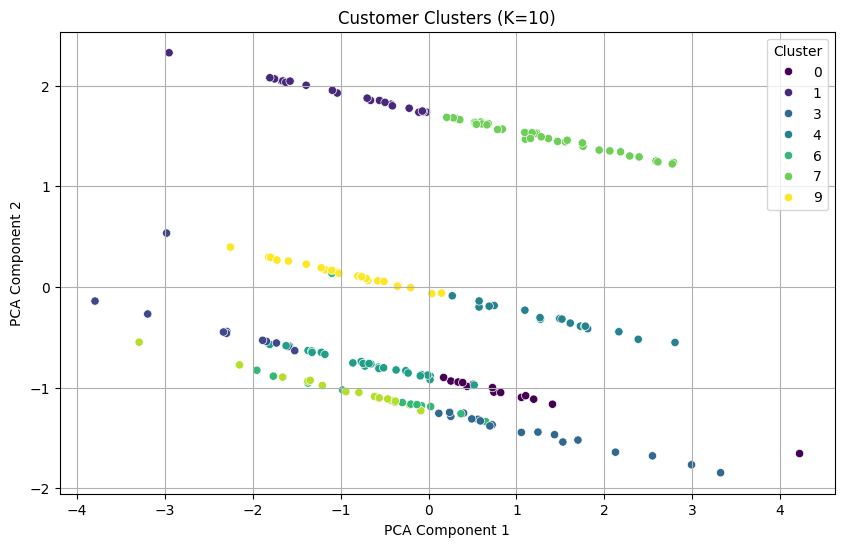

In [18]:
# Visualize clusters using PCA
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_features)
customer_features['PCA1'] = pca_components[:, 0]
customer_features['PCA2'] = pca_components[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=customer_features, x='PCA1', y='PCA2', hue='Cluster', palette='viridis')
plt.title(f"Customer Clusters (K={optimal_clusters})")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()

In [19]:
# Report results
print(f"Optimal Number of Clusters: {optimal_clusters}")
print(f"DB Index for Optimal Clustering: {min(db_indices, key=lambda x: x[1])[1]}")
print("Other Clustering Metrics:")
print(silhouette_scores)

Optimal Number of Clusters: 10
DB Index for Optimal Clustering: 0.9481181696460924
Other Clustering Metrics:
[(2, 0.20254808509653913), (3, 0.28264329715040665), (4, 0.3168976025233732), (5, 0.3290997134266653), (6, 0.3433543143335285), (7, 0.34658926108998234), (8, 0.2989633564101463), (9, 0.3002903905531094), (10, 0.3473923780437699)]
